In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = False

class DogsVsCats():
    IMG_SIZE = 50
    CATS = 'dataset/images/Cat'
    DOGS = 'dataset/images/Dog'
    LABELS = {CATS: 0, DOGS: 1}
    
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img , (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                    #np.eye (converts to one hot vector)
                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
        
        np.random.shuffle(self.training_data)
        np.save("training_data.npy",self.training_data)
        print("cats",self.catcount)
        print("dogs",self.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVsCats()
    dogsvcats.make_training_data()

100%|██████████| 12501/12501 [02:38<00:00, 78.70it/s] 


cats 0
dogs 12470


In [3]:
training_data = np.load("training_data.npy",allow_pickle = True)

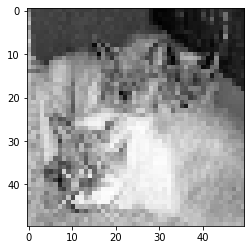

In [4]:
import matplotlib.pyplot as plt
plt.imshow(training_data[1][0], cmap = "gray")
plt.show()

In [8]:
training_data[0][1]

array([1., 0.])

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) #input, output features, kernel_size
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.rand(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512,2)
        
        
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        
        return x
    
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1,self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.softmax(x, dim = 1)
        

net = Net()

In [28]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print('val_size',val_size)

val_size 2494


In [29]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [30]:
BATCH_SIZE = 100
EPOCHS = 1
for epoch in range(EPOCHS):
    for i in tqdm(range(0,len(train_X),BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs,batch_y)
        loss.backward()
        optimizer.step()
        
print(loss)

100%|██████████| 225/225 [01:09<00:00,  3.22it/s]

tensor(0.1951, grad_fn=<MseLossBackward>)


In [31]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1

print("accuracy",round(correct/total,2))

100%|██████████| 2494/2494 [00:03<00:00, 697.18it/s]

accuracy 0.68


### TO EXECUTE ON GPU TRY CODE BELOW

In [24]:
torch.cuda.is_available()
torch.cuda.device_count()

False

In [ ]:
device = torch.device("cuda:0")

In [25]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [26]:
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:
#code to run on desired device (GPU/CPU)
net = Net().to(device)

BATCH_SIZE = 100
EPOCHS = 1

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

for epoch in range(EPOCHS):
    for i in tqdm(range(0,len(train_X),BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50).to(device) #.to(device) takes it on GPU
        batch_y = train_y[i:i+BATCH_SIZE].to(device)
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs,batch_y)
        loss.backward()
        optimizer.step()
        
print(loss)


correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i]).to(device)
        net_out = net(test_X[i].view(-1,1,50,50).to(device))[0]
        
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1

print("accuracy",round(correct/total,2))